# Epipolar Geometry

### Computing the epipolar lines:
#### 1. using SIFT to find correspondeces in the image
#### 2. Find the fundamental matrix 
#### 3. Find the epipolar lines

So first we need to find as many possible matches between two images to find the fundamental matrix. For this, we use SIFT descriptors with FLANN based matcher and ratio test.

In [4]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

two_image_data = np.load('images/TwoImageDataCar.npy', allow_pickle=True).item()

img1 = two_image_data["im1"]
img2 = two_image_data["im2"]


img1 = cv.cvtColor(img1, cv.COLOR_BGR2GRAY)
img2 = cv.cvtColor(img2, cv.COLOR_BGR2GRAY)

sift = cv.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

# FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)

flann = cv.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1,des2,k=2)

pts1 = []
pts2 = []

# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.8*n.distance:
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)

Now we have the list of best matches from both the images. Let's find the Fundamental Matrix.

In [5]:
pts1 = np.int32(pts1)
pts2 = np.int32(pts2)
F, mask = cv.findFundamentalMat(pts1,pts2,cv.FM_LMEDS) ##It uses 8-point alghoritm plus RANSAC to estimate the matrix
# Forms a set of equations based on the point correspondences.
# Uses a numerical method (like the 8-point algorithm) to solve these equations.
# Applies a robust method (like RANSAC) to handle outliers and refine the estimation.
# We select only inlier points
pts1 = pts1[mask.ravel()==1]
pts2 = pts2[mask.ravel()==1]

Next we find the epilines. Epilines corresponding to the points in first image is drawn on second image. So mentioning of correct images are important here. We get an array of lines. So we define a new function to draw these lines on the images.

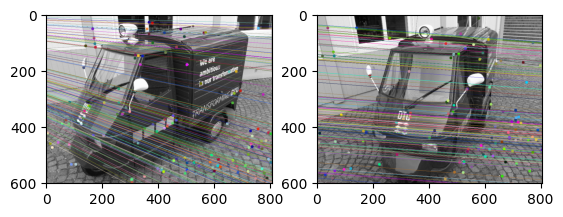

In [7]:
def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
    lines - corresponding epilines '''
    r,c = img1.shape
    img1 = cv.cvtColor(img1,cv.COLOR_GRAY2BGR)
    img2 = cv.cvtColor(img2,cv.COLOR_GRAY2BGR)
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv.line(img1, (x0,y0), (x1,y1), color,1)
        img1 = cv.circle(img1,tuple(pt1),5,color,-1)
        img2 = cv.circle(img2,tuple(pt2),5,color,-1)
    return img1,img2

# Find epilines corresponding to points in right image (second image) and
# drawing its lines on left image
lines1 = cv.computeCorrespondEpilines(pts2.reshape(-1,1,2), 2,F)
lines1 = lines1.reshape(-1,3)
img5,img6 = drawlines(img1,img2,lines1,pts1,pts2)

# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines2 = cv.computeCorrespondEpilines(pts1.reshape(-1,1,2), 1,F)
lines2 = lines2.reshape(-1,3)
img3,img4 = drawlines(img2,img1,lines2,pts2,pts1)

plt.subplot(121),plt.imshow(img5)
plt.subplot(122),plt.imshow(img3)
plt.show()